# APPARIEMENT

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# --- Étape 1 : Génération des données fictives ---
np.random.seed(42)
n = 200  # Nombre d'observations

data = pd.DataFrame({
    'age': np.random.randint(20, 60, n),
    'education': np.random.randint(0, 5, n),  # Niveau d'éducation (0=aucune, 4=très élevé)
    'experience': np.random.randint(0, 40, n),  # Années d'expérience
    'treatment': np.random.choice([0, 1], size=n, p=[0.5, 0.5])  # 0 = contrôle, 1 = traitement
})

# Création d'un salaire fictif basé sur ces variables
data['salary'] = (
    2000 + 50 * data['age'] + 500 * data['education'] + 30 * data['experience'] +
    500 * data['treatment'] + np.random.normal(0, 500, n)  # Effet du traitement + bruit
)

In [3]:
data.head()

,age,education,experience,treatment,salary
0,58,3,13,1,7429.878675
1,48,2,27,0,4839.522578
2,34,4,4,0,5590.690362
3,27,2,29,0,5066.641800
4,40,3,4,0,4857.854733


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         200 non-null    int32  
 1   education   200 non-null    int32  
 2   experience  200 non-null    int32  
 3   treatment   200 non-null    int32  
 4   salary      200 non-null    float64
dtypes: float64(1), int32(4)
memory usage: 4.8 KB


In [5]:
# --- Étape 2 : Estimation du score de propension ---
X = data[['age', 'education', 'experience']]
y = data['treatment']

logit = LogisticRegression()
logit.fit(X, y)
data['propensity_score'] = logit.predict_proba(X)[:, 1]  # Probabilité d'être traitéa

In [6]:
# --- Étape 3 : Apparier les individus traités et non traités ---
treated = data[data['treatment'] == 1]
control = data[data['treatment'] == 0]

# Utilisation des plus proches voisins pour l'appariement
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Création du dataset apparié
matched_control = control.iloc[indices.flatten()]
matched_data = pd.concat([treated.reset_index(drop=True), matched_control.reset_index(drop=True)])


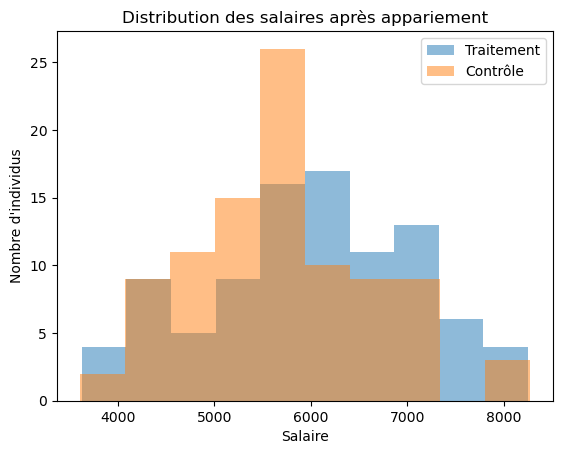

In [7]:
# --- Étape 4 : Comparer les salaires après appariement ---
plt.hist(matched_data[matched_data['treatment'] == 1]['salary'], alpha=0.5, label="Traitement")
plt.hist(matched_data[matched_data['treatment'] == 0]['salary'], alpha=0.5, label="Contrôle")
plt.legend()
plt.xlabel("Salaire")
plt.ylabel("Nombre d'individus")
plt.title("Distribution des salaires après appariement")
plt.show()

In [8]:
# --- Étape 5 : Calcul de la différence moyenne de salaire ---
mean_treated_salary = matched_data[matched_data['treatment'] == 1]['salary'].mean()
mean_control_salary = matched_data[matched_data['treatment'] == 0]['salary'].mean()
impact = mean_treated_salary - mean_control_salary

print(f"Différence moyenne de salaire entre les deux groupes après appariement : {impact:.2f} FCFA")


Différence moyenne de salaire entre les deux groupes après appariement : 338.43 FCFA


# Métrique

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, log_loss

# Prédiction des classes et des probabilités
y_pred = logit.predict(X)
y_proba = logit.predict_proba(X)[:, 1]

# Calcul des métriques
accuracy = accuracy_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)
auc_roc = roc_auc_score(y, y_proba)
logloss = log_loss(y, y_proba)

# Affichage des résultats
print(f"Précision (Accuracy) : {accuracy:.4f}")
print(f"AUC-ROC : {auc_roc:.4f}")
print(f"Log-loss : {logloss:.4f}")
print("Matrice de confusion :")
print(conf_matrix)


Précision (Accuracy) : 0.5300
AUC-ROC : 0.5194
Log-loss : 0.6909
Matrice de confusion :
[[106   0]
 [ 94   0]]


# Analyse des résultats du modèle de régression logistique :

Précision (Accuracy) = 53%

→ Le modèle ne fait guère mieux qu’un tirage au sort (50%).

AUC-ROC = 0.5194

→ Le modèle a une faible capacité à distinguer les groupes traitement et contrôle (une valeur proche de 0.5 signifie qu’il classe aléatoirement).

Log-loss = 0.6909

→ Indique que les probabilités prédites ne sont pas bien calibrées.

→ Le modèle prédit uniquement une seule classe (aucun individu classé comme traité). Cela signifie probablement que la régression logistique n'arrive pas à capter une distinction claire entre les groupes.



Statistiques descriptives des groupes :
             age                                                       \
           count       mean        std   min    25%   50%   75%   max   
treatment                                                               
0          106.0  39.500000  12.018438  20.0  28.00  40.5  51.0  59.0   
1           94.0  39.659574  12.100434  20.0  28.25  41.5  49.0  59.0   

          education            ...           experience                        \
              count      mean  ...  75%  max      count       mean        std   
treatment                      ...                                              
0             106.0  1.990566  ...  3.0  4.0      106.0  20.018868  11.607864   
1              94.0  1.914894  ...  3.0  4.0       94.0  20.265957  11.127971   

                                        
           min   25%   50%   75%   max  
treatment                               
0          0.0  11.0  20.0  30.0  39.0  
1          0.0  11.0  20

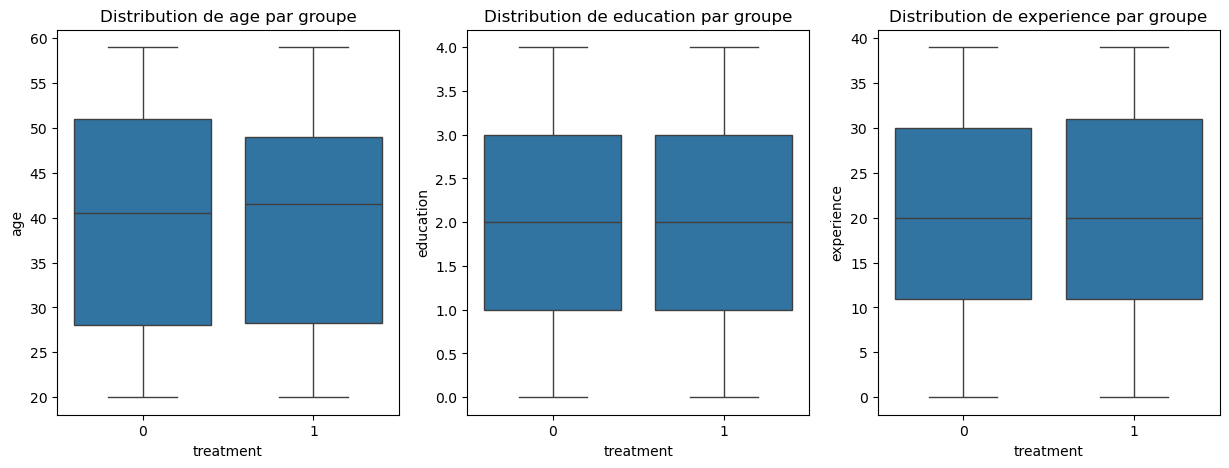

In [10]:
import seaborn as sns
import scipy.stats as stats

# Séparation des groupes
treated = data[data['treatment'] == 1]
control = data[data['treatment'] == 0]

# 1. Statistiques descriptives
print("Statistiques descriptives des groupes :")
print(data.groupby("treatment")[["age", "education", "experience"]].describe())

# 2. Tests statistiques (Test de Student si normalité, sinon Mann-Whitney)
def compare_groups(variable):
    stat, p_value = stats.ttest_ind(treated[variable], control[variable], equal_var=False)
    print(f"\nTest de Student pour {variable} : p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("⛔ Différence significative entre les groupes")
    else:
        print("✅ Pas de différence significative entre les groupes")

for var in ["age", "education", "experience"]:
    compare_groups(var)

# 3. Visualisation des distributions
plt.figure(figsize=(15, 5))
for i, var in enumerate(["age", "education", "experience"], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x="treatment", y=var, data=data)
    plt.title(f"Distribution de {var} par groupe")
plt.show()


# Testons plusieurs modéle

# 1. Importer les bibliothèques nécessaires


In [11]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# 2. Définir les modèles à tester avec leurs hyperparamètres

In [26]:
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000), {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga']
    }),
    ('Random Forest', RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }),
    ('Gradient Boosting', GradientBoostingClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5, 1],
        'max_depth': [3, 5, 7]
    }),
    ('SVM', SVC(), {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf']
    })
]

# 3. Diviser les données en ensembles d'entraînement et de test

In [27]:
# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 4. Effectuer la recherche par grille pour chaque modèle et récupérer les résultats

In [28]:
results = []

# Parcourir chaque modèle et effectuer la recherche par grille
for name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    results.append((name, grid_search.best_params_, -grid_search.best_score_))


C:\python\environement python\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\python\environement python\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\python\environement python\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\python\environement python\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\python\environement python\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\python\environement python\anaconda\L

# 5. Afficher les résultats des meilleurs paramètres et des meilleures MSE

In [29]:
# Afficher les résultats
for result in results:
    print(f"{result[0]}: Best Params: {result[1]}, Best MSE: {result[2]:.4f}")


Logistic Regression: Best Params: {'C': 10, 'solver': 'liblinear'}, Best MSE: 0.5000
Random Forest: Best Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}, Best MSE: 0.4875
Gradient Boosting: Best Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}, Best MSE: 0.4500
SVM: Best Params: {'C': 0.1, 'kernel': 'rbf'}, Best MSE: 0.4813


# 6. Évaluer le meilleur modèle sur l'ensemble de test

In [32]:
# Sélectionner le meilleur modèle
best_model_name, best_model_params, best_model_mse = min(results, key=lambda x: x[2])

# Trouver l'instance du meilleur modèle
best_model = None
for name, model, param_grid in models:
    if name == best_model_name:
        best_model = model
        break

# Réentraîner le meilleur modèle avec les meilleurs hyperparamètres
best_model.set_params(**best_model_params)
best_model.fit(X_train, y_train)

# Prédire les résultats sur l'ensemble de test
y_pred_test = best_model.predict(X_test)

# Calculer la MSE sur l'ensemble de test
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"MSE sur l'ensemble de test : {mse_test:.4f}")


MSE sur l'ensemble de test : 0.5000


# Raisons possibles d'un MSE de 0.5000 sur l'ensemble de test :
Modèle sous-optimal : Votre modèle peut ne pas avoir capturé suffisamment d'informations de manière précise. Cela pourrait être dû à un problème
d'overfitting, d'underfitting ou de mauvais réglages des hyperparamètres.

Hétérogénéité des données : Si les données sont très diverses ou comportent beaucoup de bruit, un MSE plus élevé est souvent observé.

Distribution des classes (s'il s'agit d'une classification) : Si vos classes sont déséquilibrées ou très différentes en termes de fréquence, le MSE peut ne pas capturer pleinement la performance du modèle,

car il peut être biaisé par une classe plus fréquente.

Comparaison avec d'autres modèles : Parfois, un MSE de 0.5000 peut être un bon résultat dans certains contextes mais pourrait être amélioré par des modèles plus performants ou des ajustements supplémentaires.

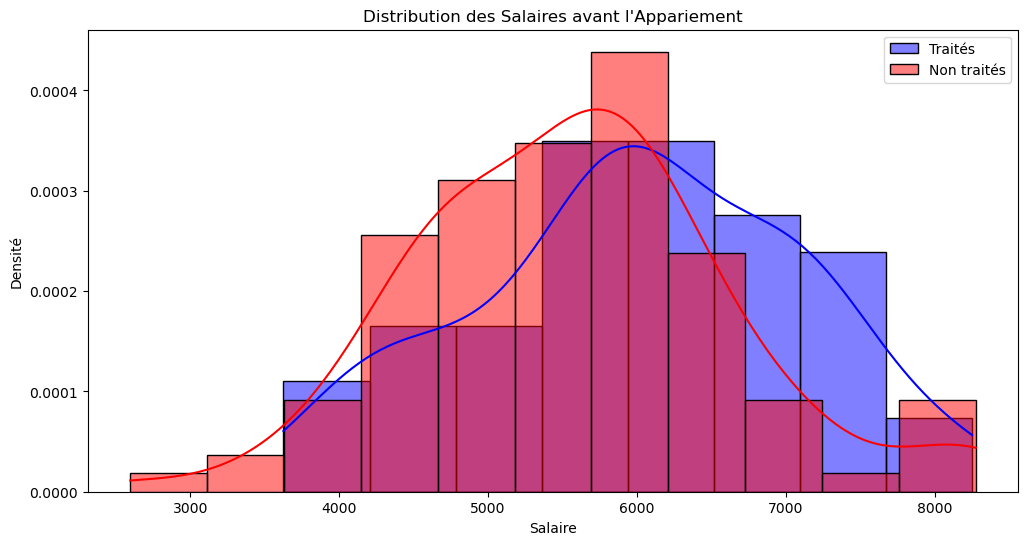

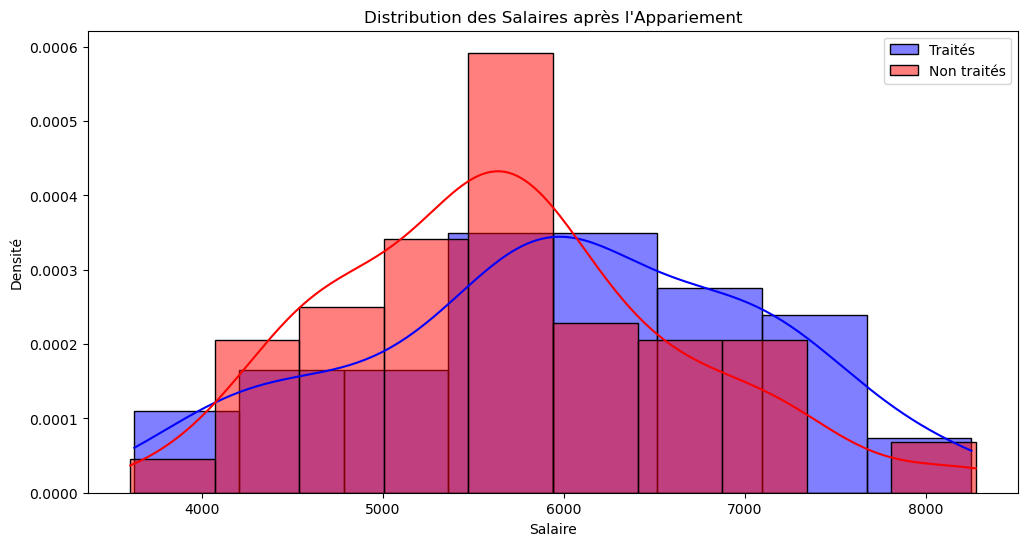

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution des salaires avant l'appariement
plt.figure(figsize=(12, 6))
sns.histplot(data['salary'][data['treatment'] == 1], color='blue', kde=True, label='Traités', stat='density')
sns.histplot(data['salary'][data['treatment'] == 0], color='red', kde=True, label='Non traités', stat='density')

plt.title("Distribution des Salaires avant l'Appariement")
plt.xlabel("Salaire")
plt.ylabel("Densité")
plt.legend()
plt.show()

# Distribution des salaires après appariement
plt.figure(figsize=(12, 6))
sns.histplot(matched_data['salary'][matched_data['treatment'] == 1], color='blue', kde=True, label='Traités', stat='density')
sns.histplot(matched_data['salary'][matched_data['treatment'] == 0], color='red', kde=True, label='Non traités', stat='density')

plt.title("Distribution des Salaires après l'Appariement")
plt.xlabel("Salaire")
plt.ylabel("Densité")
plt.legend()
plt.show()


In [34]:
# Prédire les salaires avec le meilleur modèle après appariement
best_model.fit(X_train, y_train)

# Prédire les scores sur l'ensemble apparié (traités et non traités)
matched_data['predicted_salary'] = best_model.predict(matched_data[['age', 'education', 'experience']])

# Calcul des salaires moyens pour les groupes traités et non traités après appariement
mean_treated_salary = matched_data[matched_data['treatment'] == 1]['predicted_salary'].mean()
mean_control_salary = matched_data[matched_data['treatment'] == 0]['predicted_salary'].mean()

# Calcul de l'impact (différence moyenne de salaire)
impact = mean_treated_salary - mean_control_salary

# Affichage de la différence
print(f"Différence moyenne de salaire entre les deux groupes après appariement : {impact:.2f} FCFA")


Différence moyenne de salaire entre les deux groupes après appariement : 0.65 FCFA


# Avec une standaristaion

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
import pandas as pd

# --- Étape 1 : Charger les données (exemple) ---
# data = pd.read_csv("votre_fichier.csv")

# --- Étape 2 : Standardisation des données ---
scaler = StandardScaler()
X = data[['age', 'education', 'experience']]  # Variables explicatives

# Standardiser les variables explicatives
X_scaled = scaler.fit_transform(X)

# Estimation du score de propension
y = data['treatment']
logit = LogisticRegression()
logit.fit(X_scaled, y)
data['propensity_score'] = logit.predict_proba(X_scaled)[:, 1]  # Probabilité d'être traité

# --- Étape 3 : Apparier les individus traités et non traités ---
treated = data[data['treatment'] == 1]
control = data[data['treatment'] == 0]

# Utilisation des plus proches voisins pour l'appariement
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])  # Apparier selon le score de propension
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Création du dataset apparié
matched_control = control.iloc[indices.flatten()]
matched_data = pd.concat([treated.reset_index(drop=True), matched_control.reset_index(drop=True)])

# Affichage du résultat de l'appariement
print(matched_data.head())


   age  education  experience  treatment       salary  propensity_score
0   58          3          13          1  7429.878675          0.463197
1   58          3          11          1  7628.868157          0.462348
2   42          3          25          1  6983.871333          0.463283
3   30          2          25          1  7141.888712          0.468617
4   30          1          20          1  4294.497195          0.475596


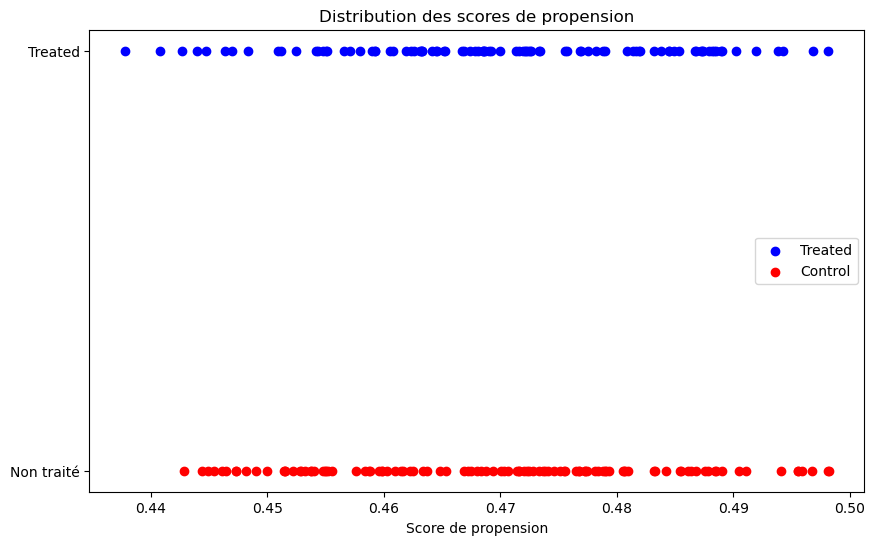

In [36]:
import matplotlib.pyplot as plt

# Affichage des scores de propension pour les groupes traités et non traités
plt.figure(figsize=(10, 6))
plt.scatter(data[data['treatment'] == 1]['propensity_score'], [1] * len(data[data['treatment'] == 1]), color='blue', label='Treated')
plt.scatter(data[data['treatment'] == 0]['propensity_score'], [0] * len(data[data['treatment'] == 0]), color='red', label='Control')

plt.title('Distribution des scores de propension')
plt.xlabel('Score de propension')
plt.yticks([0, 1], ['Non traité', 'Treated'])
plt.legend()
plt.show()


In [38]:
# --- Étape 2 : Estimation de la différence moyenne de salaire ---
mean_treated_salary = matched_data[matched_data['treatment'] == 1]['salary'].mean()
mean_control_salary = matched_data[matched_data['treatment'] == 0]['salary'].mean()

# Calcul de l'impact
impact = mean_treated_salary - mean_control_salary

print(f"Différence moyenne de salaire entre les deux groupes après appariement : {impact:.2f} FCFA")


Différence moyenne de salaire entre les deux groupes après appariement : 467.65 FCFA


# Test de student

pour vérifier si il y'a une différence significative entre les moyennes des deux groupes

In [39]:
from scipy import stats

# Extraire les salaires des groupes traités et non traités après appariement
treated_salary = matched_data[matched_data['treatment'] == 1]['salary']
control_salary = matched_data[matched_data['treatment'] == 0]['salary']

# Test t de Student pour échantillons indépendants
t_stat, p_value = stats.ttest_ind(treated_salary, control_salary)

# Affichage des résultats
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interprétation
if p_value < 0.05:
    print("Il y a une différence significative entre les salaires des groupes traités et non traités.")
else:
    print("Il n'y a pas de différence significative entre les salaires des groupes traités et non traités.")


T-statistic: 3.2259
P-value: 0.0015
Il y a une différence significative entre les salaires des groupes traités et non traités.




Les résultats du test t de Student indiquent que la p-value est de 0.0015, ce qui est bien inférieur à 0.05. 

Cela signifie qu'il y a une différence statistiquement significative entre les salaires des groupes traités et non traités.

En d'autres termes, l'effet du traitement (ou de l'intervention) semble avoir un impact sur les salaires, 

et cette différence est suffisamment forte pour être considérée comme significative sur le plan statistique.